In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
jp_sales_df = pd.read_csv('data/Japan/Japan_console_weekly_sales.csv')
jp_gdp_df = pd.read_csv('data/Japan/Japan_GDP.csv', delimiter=';')
jp_ir_df = pd.read_csv('data/Japan/Japan_IR.csv', delimiter=';')
jp_unemployment_df = pd.read_csv('data/Japan/Japan_Unemployment.csv', delimiter=';')

jp_sales_df['week'] = pd.to_datetime(jp_sales_df['week'])
jp_sales_df['year'] = jp_sales_df['week'].dt.year

annual_sales = jp_sales_df.groupby('year')['sales'].sum().reset_index()
annual_sales['millions'] = annual_sales['sales'] / 1_000_000

jp_gdp_df['GDP'] = jp_gdp_df['GDP'] / 1_000_000_000_000

jp_merged_df = pd.merge(annual_sales, jp_gdp_df, on='year', how='inner')
jp_merged_df = pd.merge(jp_merged_df, jp_ir_df, on='year', how='inner')
jp_merged_df = pd.merge(jp_merged_df, jp_unemployment_df, on='year', how='inner')

jp_merged_df


,year,sales,millions,GDP,inflation_rate,unemployment
0,2004,1557436,1.557436,4.893116,-0.01,4.73
1,2005,6838566,6.838566,4.831467,-0.28,4.45
2,2006,11891162,11.891162,4.601663,0.25,4.19
3,2007,15382788,15.382788,4.579751,0.06,3.89
4,2008,11830491,11.830491,5.106679,1.38,4.00
5,2009,10405854,10.405854,5.289493,-1.35,5.07
6,2010,9489078,9.489078,5.759072,-0.73,5.10
7,2011,10305503,10.305503,6.233147,-0.27,4.55
8,2012,9528430,9.528430,6.272363,-0.04,4.36
9,2013,8360746,8.360746,5.212328,0.34,4.04


<Axes: xlabel='year'>

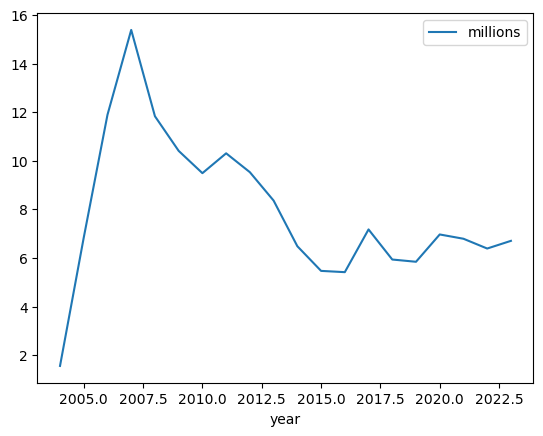

In [4]:
jp_merged_df.plot(kind='line', x='year', y='millions')

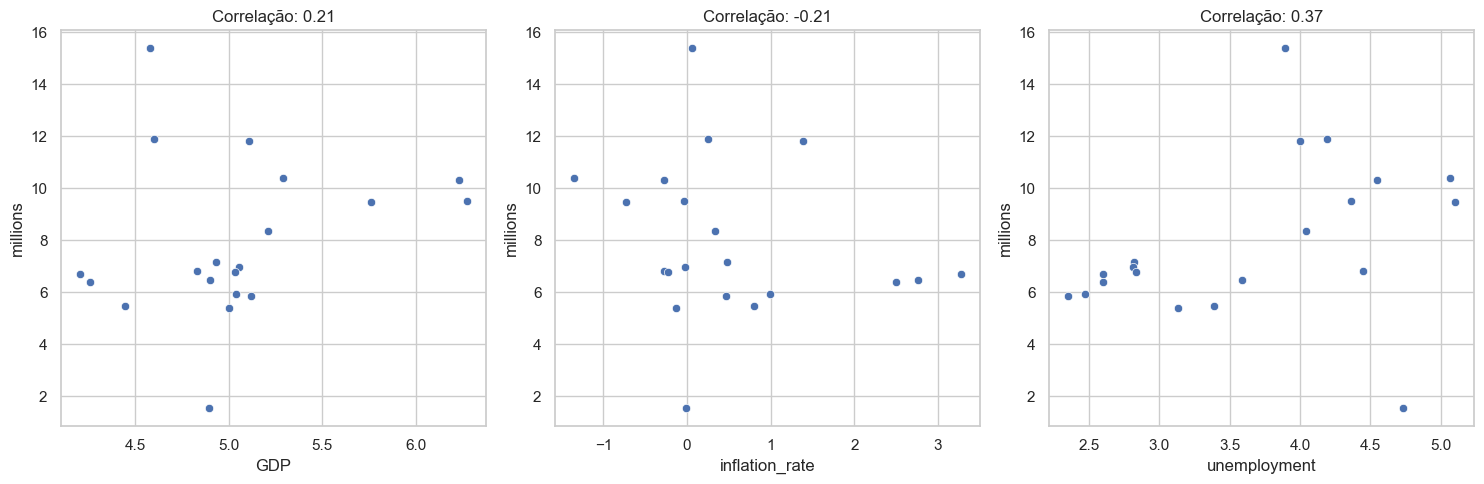

In [12]:
correlation_matrix = merged_df[['millions', 'GDP', 'inflation_rate', 'unemployment']].corr()
correlation_millions = correlation_matrix.loc['millions', ['GDP', 'inflation_rate', 'unemployment']]

plt.figure(figsize=(15, 5))

# millions vs GDP
plt.subplot(1, 3, 1)
sns.scatterplot(data=merged_df, x='GDP', y='millions')
plt.title(f"Correlação: {correlation_millions['GDP']:.2f}")

# millions vs inflation_rate
plt.subplot(1, 3, 2)
sns.scatterplot(data=merged_df, x='inflation_rate', y='millions')
plt.title(f"Correlação: {correlation_millions['inflation_rate']:.2f}")

# millions vs unemployment
plt.subplot(1, 3, 3)
sns.scatterplot(data=merged_df, x='unemployment', y='millions')
plt.title(f"Correlação: {correlation_millions['unemployment']:.2f}")

plt.tight_layout()
plt.show()

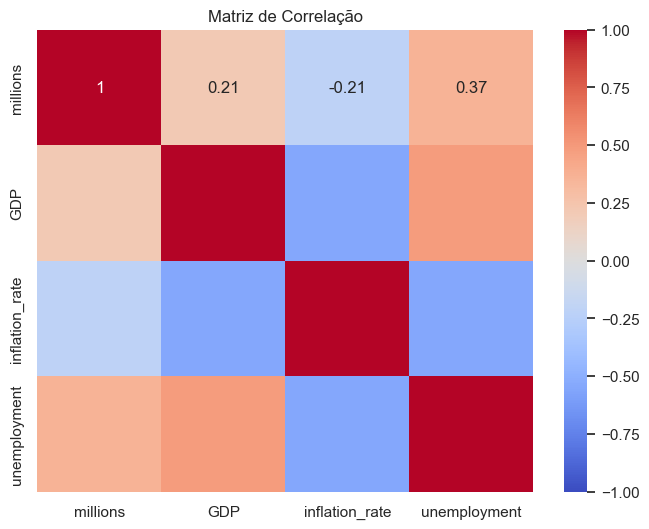

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlação")
plt.show()

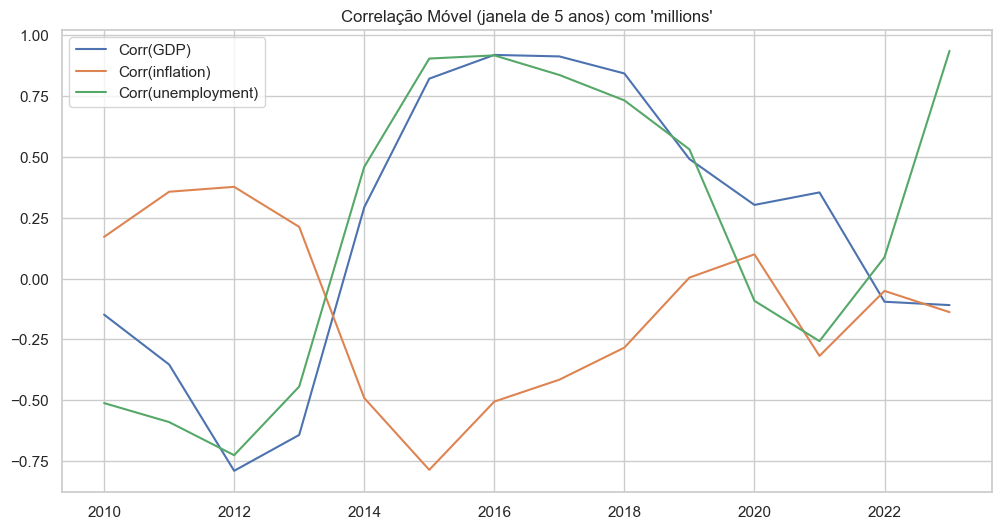

In [21]:
# Exemplo: correlação móvel em uma janela de 5 anos
merged_df['rolling_corr_GDP'] = merged_df['millions'].rolling(window=7).corr(merged_df['GDP'])
merged_df['rolling_corr_inflation'] = merged_df['millions'].rolling(window=7).corr(merged_df['inflation_rate'])
merged_df['rolling_corr_unemployment'] = merged_df['millions'].rolling(window=7).corr(merged_df['unemployment'])

# Plotar as correlações ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(merged_df['year'], merged_df['rolling_corr_GDP'], label='Corr(GDP)')
plt.plot(merged_df['year'], merged_df['rolling_corr_inflation'], label='Corr(inflation)')
plt.plot(merged_df['year'], merged_df['rolling_corr_unemployment'], label='Corr(unemployment)')
plt.legend()
plt.title("Correlação Móvel (janela de 5 anos) com 'millions'")
plt.show()

<Figure size 1200x800 with 0 Axes>

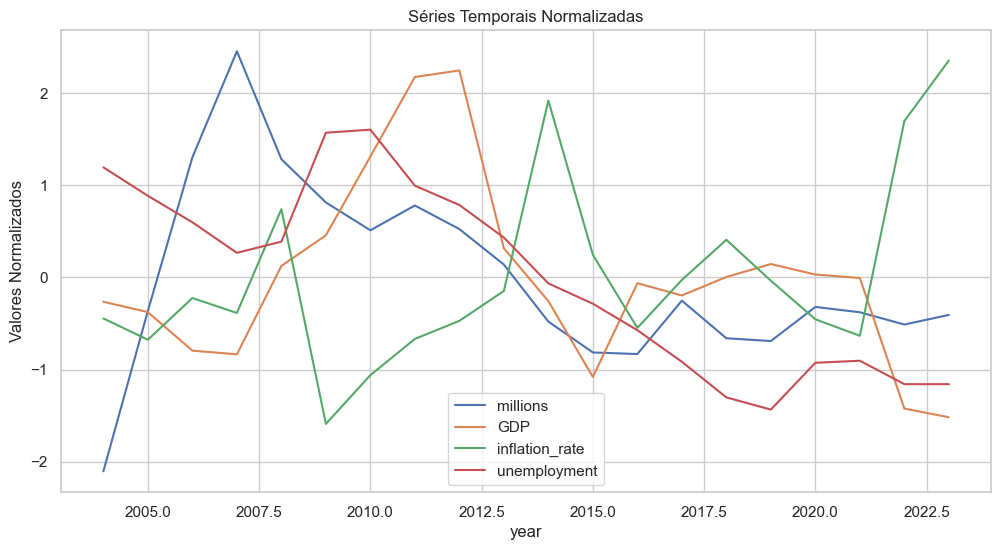

In [20]:
plt.figure(figsize=(12, 8))

# Normalizar as variáveis para plotar no mesmo gráfico (opcional)
normalized_df = (merged_df[['year', 'millions', 'GDP', 'inflation_rate', 'unemployment']]
                .set_index('year')
                .apply(lambda x: (x - x.mean()) / x.std()))

normalized_df.plot(figsize=(12, 6))
plt.title("Séries Temporais Normalizadas")
plt.ylabel("Valores Normalizados")
plt.show()

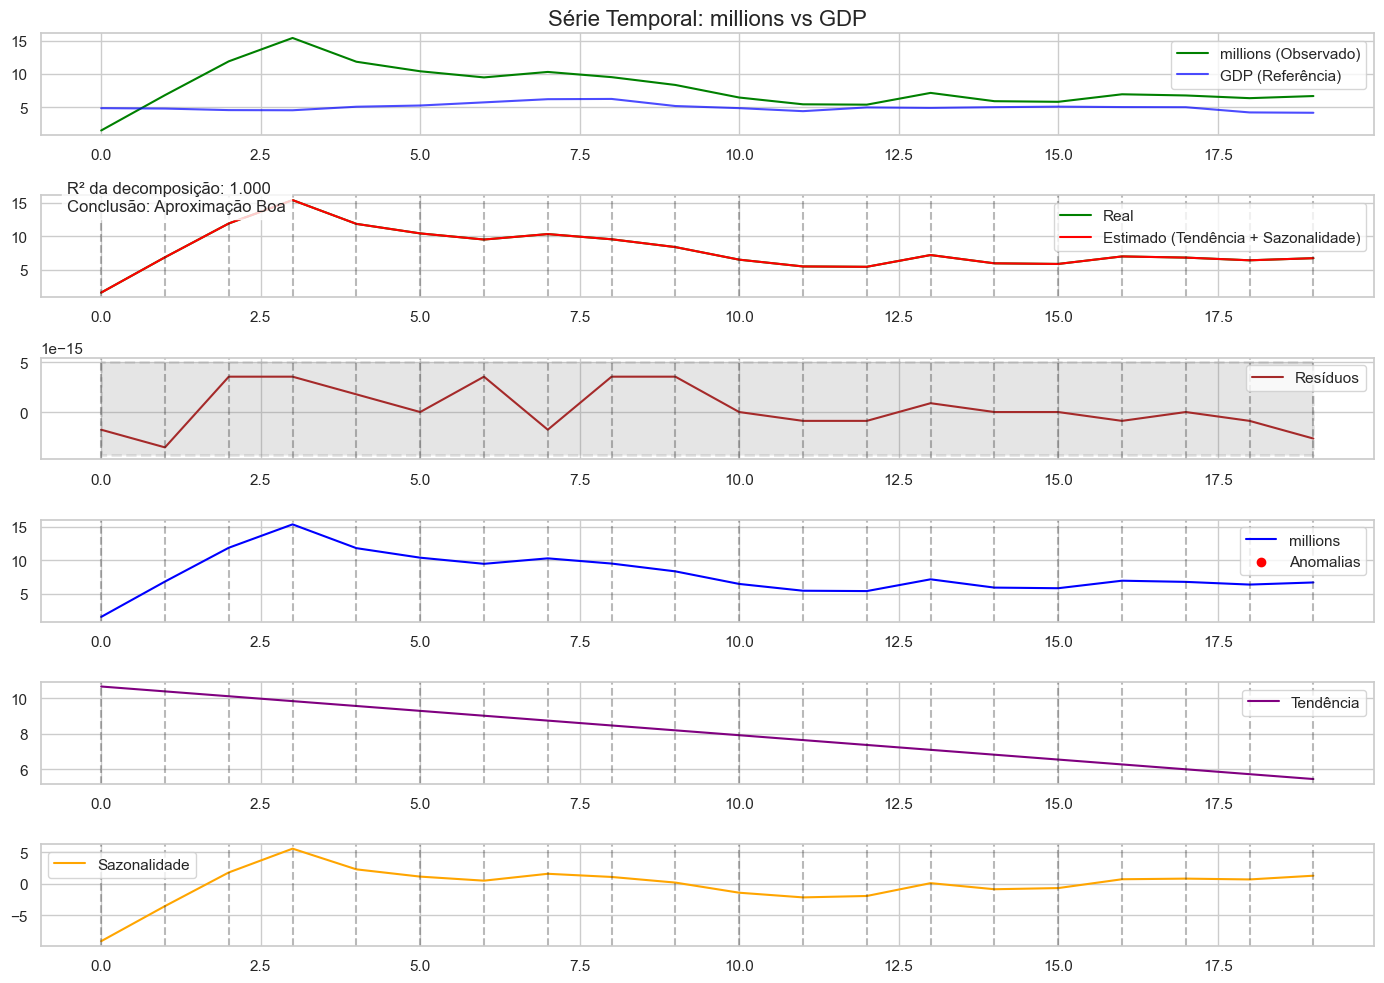

Correlação entre 'millions' e 'GDP': 0.214



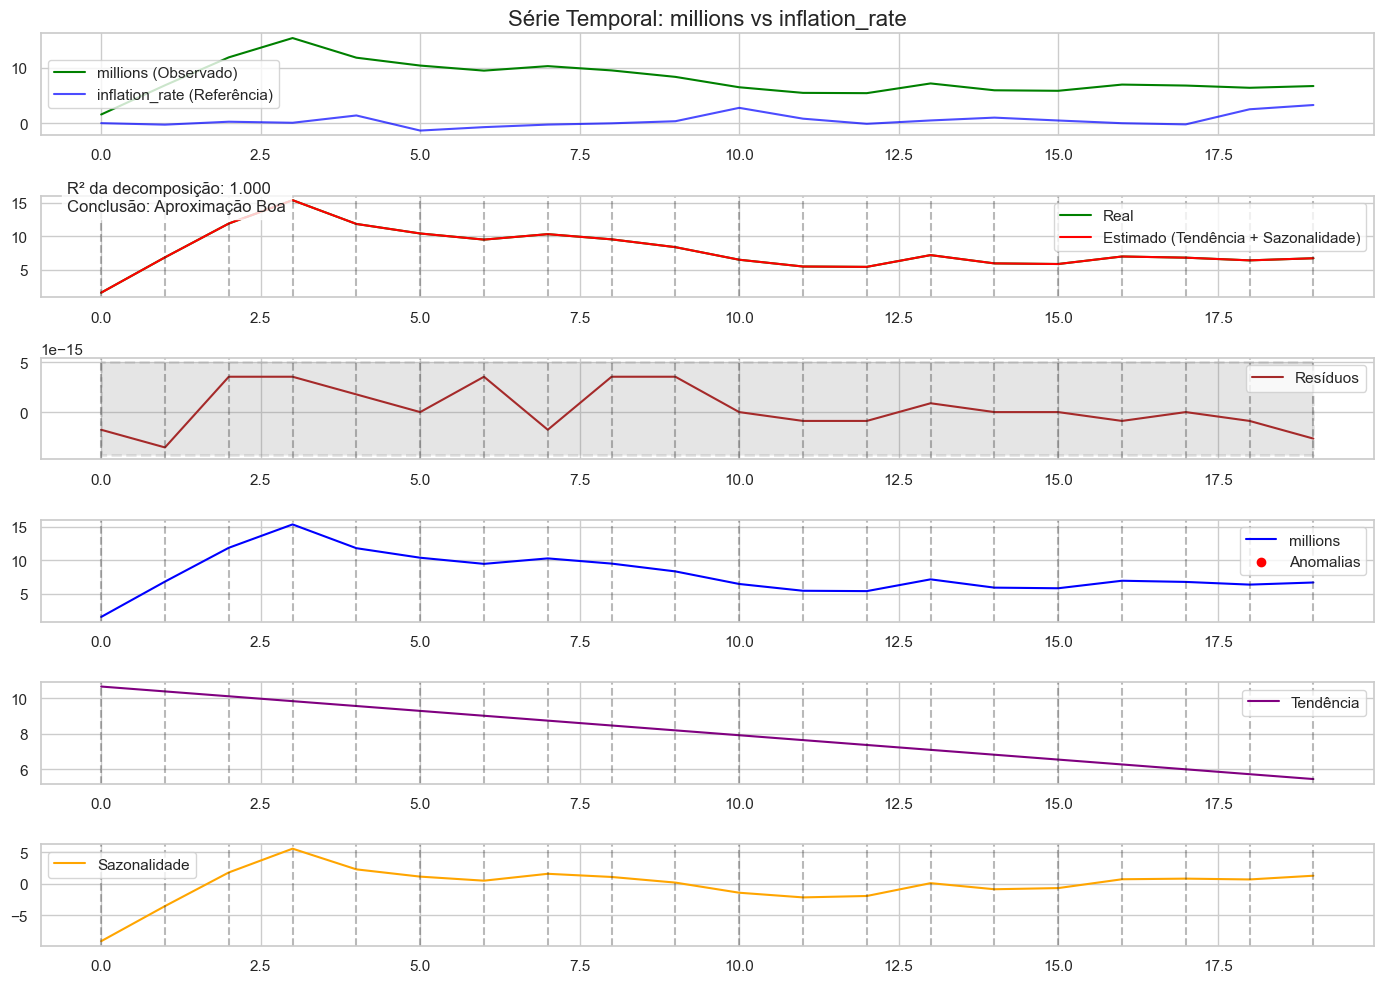

Correlação entre 'millions' e 'inflation_rate': -0.214



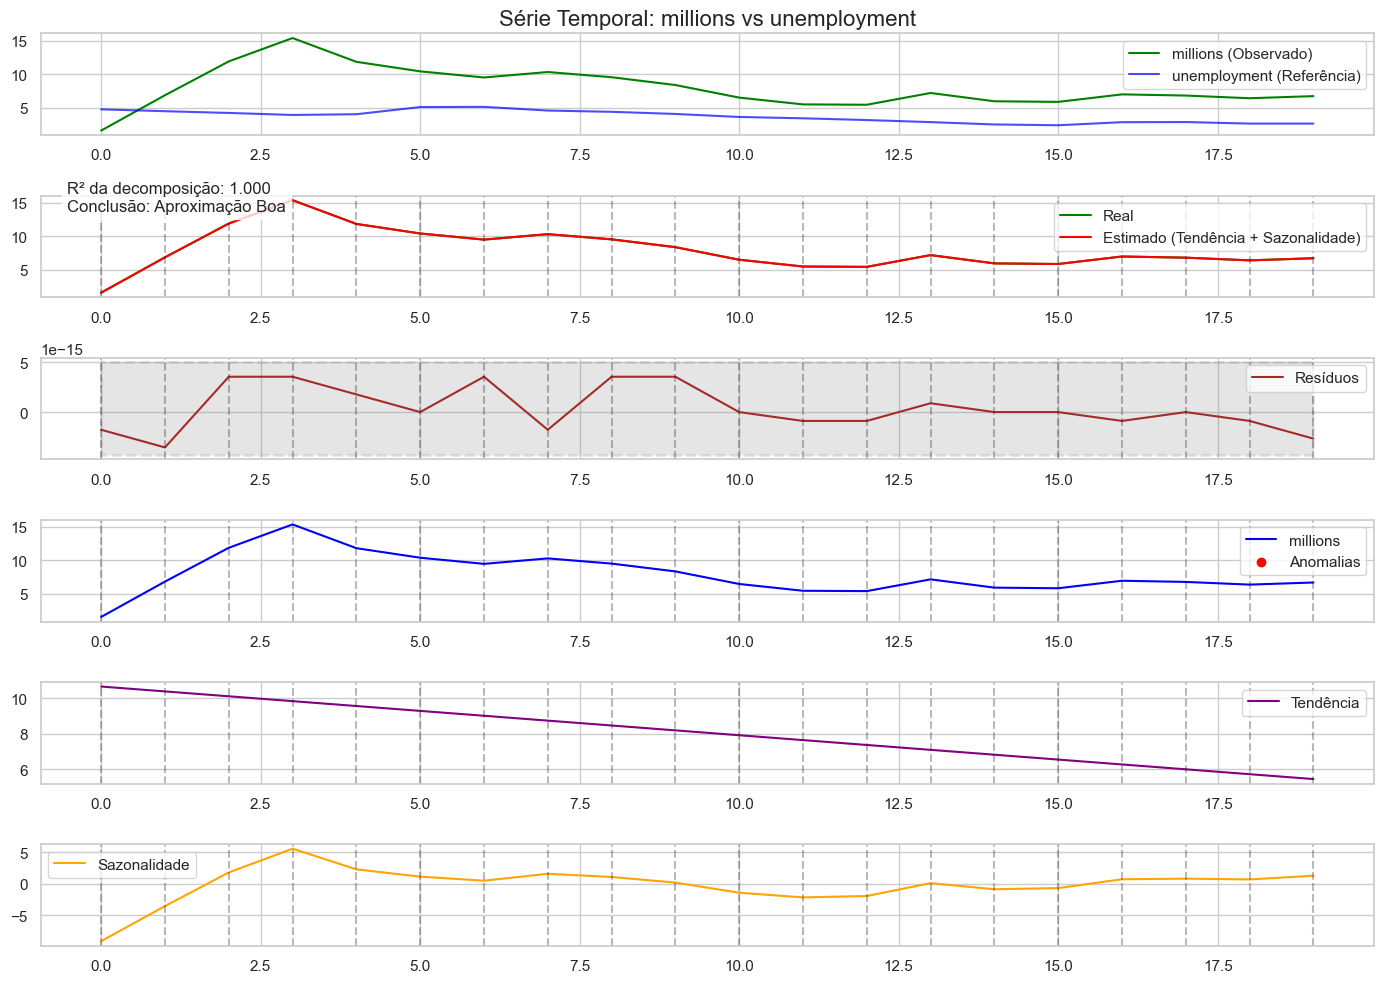

Correlação entre 'millions' e 'unemployment': 0.367



In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from datetime import datetime
import scipy.stats

# Supondo que seu DataFrame 'df' tenha uma coluna 'date' ou similar como índice temporal
# Caso não tenha, você pode criar assim:
# df['date'] = pd.to_datetime(df['year'], format='%Y')
# df.set_index('date', inplace=True)

# Variáveis a serem analisadas
variables = ['GDP', 'inflation_rate', 'unemployment']

for var in variables:
    # Seleciona a série 'millions' e a variável atual, removendo NAs e zeros
    actual_series = merged_df[['millions', var]].dropna()
    actual_series = actual_series[(actual_series['millions'] != 0) & (actual_series[var] != 0)]
    
    # Decomposição STL da série 'millions' (ajuste o período conforme seus dados)
    decomposition = STL(actual_series['millions'], period=12).fit()  # Periodo 12 para dados mensais
    
    date_min = actual_series.index.min()
    date_max = actual_series.index.max()
    
    plt.figure(figsize=(14, 10))
    
    # Série Observada (millions)
    plt.subplot(6, 1, 1)
    plt.title(f'Série Temporal: millions vs {var}', fontsize=16)
    plt.plot(actual_series['millions'], color='green', label='millions (Observado)')
    plt.plot(actual_series[var], color='blue', label=f'{var} (Referência)', alpha=0.7)
    plt.legend()
    
    # Série Estimada (Trend + Seasonal) e R²
    plt.subplot(6, 1, 2)
    ss_res = np.sum(decomposition.resid**2)
    ss_tot = np.sum((actual_series['millions'] - np.mean(actual_series['millions']))**2)
    r2 = 1 - (ss_res / ss_tot)
    
    text_test = (
        f'R² da decomposição: {r2:.3f}\n'
        f'Conclusão: {"Aproximação Insuficiente" if r2 < 0.8 else "Aproximação Boa"}'
    )
    plt.text(0.02, 0.85, text_test, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    estimated = decomposition.trend + decomposition.seasonal
    plt.plot(actual_series['millions'], color='green', label='Real')
    plt.plot(estimated, color='red', label='Estimado (Tendência + Sazonalidade)')
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Resíduos com Intervalo de Confiança
    plt.subplot(6, 1, 3)
    resid = decomposition.resid
    resid_mu = resid.mean()
    resid_dev = resid.std()
    
    dist = scipy.stats.t(df=len(resid)-1)
    critical_value = dist.ppf(0.975)
    
    lower = resid_mu - (resid_dev * critical_value)
    upper = resid_mu + (resid_dev * critical_value)
    
    plt.plot(resid, color='brown', label='Resíduos')
    plt.fill_between(resid.index, lower, upper, color='gray', alpha=0.2, linestyle='--', linewidth=2)
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Anomalias (pontos fora do intervalo de confiança)
    plt.subplot(6, 1, 4)
    anomalies = actual_series['millions'][(resid < lower) | (resid > upper)]
    plt.plot(actual_series['millions'], color='blue', label='millions')
    plt.scatter(anomalies.index, anomalies, color='red', marker='o', label='Anomalias')
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Componente de Tendência
    plt.subplot(6, 1, 5)
    plt.plot(decomposition.trend, color='purple', label='Tendência')
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Componente Sazonal
    plt.subplot(6, 1, 6)
    plt.plot(decomposition.seasonal, color='orange', label='Sazonalidade')
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Correlação entre 'millions' e a variável atual
    correlation = actual_series['millions'].corr(actual_series[var])
    print(f"Correlação entre 'millions' e '{var}': {correlation:.3f}\n")